In [1]:
#Importing require libraries
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

In [2]:
#Extracting the Zip file
from zipfile import ZipFile

file_name = "CV_Data.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    print('Extracting all the files...') 
    zip.extractall()  # extracting all the files 

Extracting all the files...


In [3]:
#definining the master class (model)
class Net(nn.Module):

    def __init__(self, num_classes=20):
        super(Net, self).__init__()
        print("inside __init__")
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.fc1   = nn.Linear(128*6*6, 20)
        self.fc1_bn = nn.BatchNorm1d(20)
    
    def forward(self, x):
        #rint("inside forward")
        out = F.relu(self.conv1_bn(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2_bn(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv3_bn(self.conv3(out)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv4_bn(self.conv4(out)))
        out = F.max_pool2d(out, 2)
        #print("out:",out.shape)
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out = F.relu(self.fc1_bn(self.fc1(out)))
        return out

def net(**kwargs):
    model = Net(**kwargs)
    return model

In [4]:
model=net(num_classes=20)
print(model)

inside __init__
Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4608, out_features=20, bias=True)
  (fc1_bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [5]:
dataset_train = torchvision.datasets.ImageFolder('AI_CV/Train',
                                          transform=transforms.Compose([
                                          transforms.Resize(126),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.2545,0.2545,0.2545],[0.3846,0.3846,0.3846])
                                          ]))

print("Loaded {} images under {}".format(len(dataset_train), "train"))

dataloaders_train = torch.utils.data.DataLoader(
            dataset_train,
            batch_size=25, shuffle=True, num_workers=4)



dataset_test = torchvision.datasets.ImageFolder('AI_CV/Test',
                                          transform=transforms.Compose([
                                          transforms.Resize(126),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.2545,0.2545,0.2545],[0.3846,0.3846,0.3846])
                                          ]))

print("Loaded {} images under {}".format(len(dataset_test), "test"))

dataloaders_test = torch.utils.data.DataLoader(
            dataset_test,
            batch_size=25, shuffle=True, num_workers=4)

print('len_train',len(dataloaders_train))
print('len_test',len(dataloaders_test))

print("Classes: ")
class_names = dataset_train.classes
print(class_names)

Loaded 1157 images under train
Loaded 277 images under test
len_train 47
len_test 12
Classes: 
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


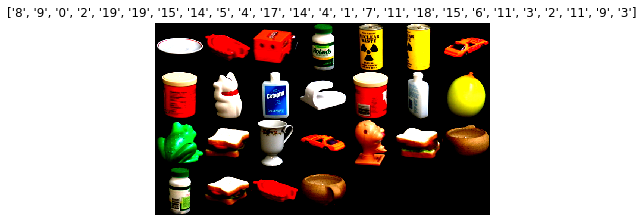

In [6]:
#Displaying a sample of input images and their associated class labels
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs,7)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders_train))
show_databatch(inputs, classes)


In [7]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0.0
    avg_acc = 0.0
    avg_loss_test = 0.0
    avg_acc_test = 0.0

    train_batches = len(dataloaders_train)
    test_batches = len(dataloaders_test)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('--' * 10)
        
        loss_train = 0
        loss_test = 0
        acc_train = 0
        acc_test = 0
        
        model.train(True)
        
        for i, data in enumerate(dataloaders_train):
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        
        avg_loss = loss_train  / len(dataset_train)
        avg_acc = float(acc_train.data) / float(len(dataset_train))
        
        model.train(False)
        model.eval()
            
        for i, data in enumerate(dataloaders_test):
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_test += loss.data
            acc_test += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_test = (loss_test) / len(dataset_test)
        avg_acc_test = float(acc_test) / float(len(dataset_test))
        
        print()
        print("Epoch {} result: ".format(epoch))
        print()
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (test): {:.4f}".format(avg_loss_test))
        print("Avg acc (test): {:.4f}".format(avg_acc_test))
        print('--' * 10)
        print()
        
        if avg_acc_test > best_acc:
            best_acc = avg_acc_test
            best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [8]:

import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable


use_gpu = torch.cuda.is_available()

if use_gpu:
    model.cuda() 


for param in model.parameters():
    param.requires_grad = True

    
criterion = nn.CrossEntropyLoss() #choosing cross entropy loss

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # choosing gradient descent optimizer
lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


print("Training....") 
train_model(model, criterion, optimizer_ft, lr_scheduler, 10) # training for 10 epochs 


Training....
Epoch 0/10
--------------------



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Epoch 0 result: 

Avg loss (train): 0.0759
Avg acc (train): 0.6984
Avg loss (test): 0.0833
Avg acc (test): 0.5596
--------------------

Epoch 1/10
--------------------


Epoch 1 result: 

Avg loss (train): 0.0535
Avg acc (train): 0.9378
Avg loss (test): 0.0512
Avg acc (test): 0.9458
--------------------

Epoch 2/10
--------------------


Epoch 2 result: 

Avg loss (train): 0.0466
Avg acc (train): 0.9706
Avg loss (test): 0.0572
Avg acc (test): 0.9495
--------------------

Epoch 3/10
--------------------


Epoch 3 result: 

Avg loss (train): 0.0442
Avg acc (train): 0.9732
Avg loss (test): 0.0503
Avg acc (test): 0.9350
--------------------

Epoch 4/10
--------------------


Epoch 4 result: 

Avg loss (train): 0.0386
Avg acc (train): 0.9818
Avg loss (test): 0.0426
Avg acc (test): 0.9639
--------------------

Epoch 5/10
--------------------


Epoch 5 result: 

Avg loss (train): 0.0366
Avg acc (train): 0.9853
Avg loss (test): 0.0379
Avg acc (test): 0.9747
--------------------

Epoch 6/10
--

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4608, out_features=20, bias=True)
  (fc1_bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [9]:
torch.save(model.state_dict(), 'assgn2_DVRakeshReddy_AI0032_DL_chkpt.pt' ) #saving the model 